# CNN Info

Tasks: Extracting information from CNNs, including weights, gradients, feature maps, etc. 

Lessons:
1. resnet18 has a hierarchial structure. Coding needs to respect this structure. 
2. check the coding tricks to see how to obtain weights, gradients, and feature maps.
3. Cool!!


# 0. Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import util
import statsmodels.api as sm
from scipy import stats
import copy
import pickle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from datetime import datetime

In [2]:
# ALWAYS choose devise first.
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
print(torch.cuda.is_available())

True


In [4]:
device

device(type='cuda', index=1)

In [5]:
print(torch.__version__)

1.8.0+cu111


In [6]:
with open('./data_shenhao/nhts/data.pickle', 'rb') as f:
    data_dic = pickle.load(f)
    # note that y is auto usage.

In [7]:
# data
y_train=data_dic['y_train']
y_test=data_dic['y_test']
x_train=data_dic['x_train']
x_test=data_dic['x_test']
train_idx=data_dic['train_idx']
test_idx=data_dic['test_idx']

In [8]:
print(y_train.shape,y_test.shape,x_train.shape,x_test.shape)

(3000,) (800,) (3000, 3, 224, 224) (800, 3, 224, 224)


In [8]:
# use basic resnet18 as a benchmark.
model = models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# get layer info for m
for name,module in model.named_modules():
    print(name) # get names.
#     print(module)  


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [10]:
# modify the last layer to fit the data
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1) # if output_type == continuous, then num_categories = 1.

# to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# process data
x_train_norm = x_train/255 # very crude processing. It is improvable.
x_test_norm = x_test/255

x_train_torch = torch.from_numpy(x_train_norm)
x_test_torch = torch.from_numpy(x_test_norm)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

# create data loader: train and test. 
train_ds = TensorDataset(x_train_torch, y_train_torch)
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

test_ds = TensorDataset(x_test_torch, y_test_torch)
batch_size = 100
test_dl = DataLoader(test_ds, batch_size, shuffle = True)


In [13]:
# hyper set up
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001) # parameters.
n_epoch = 15 # change the max n_epoch

In [14]:
# baseline MSE.
total_mse_train = criterion(y_train_torch.mean().repeat(y_train_torch.size()), y_train_torch)*y_train_torch.size()[0]
total_mse_test = criterion(y_test_torch.mean().repeat(y_test_torch.size()), y_test_torch)*y_test_torch.size()[0]
print(total_mse_train)
print(total_mse_test)


tensor(1627.3353)
tensor(478.3587)


In [15]:
# train this resnet18
mse_train_list = []
mse_test_list = []
r_square_train_list = []
r_square_test_list = []

# save the best model
best_model_wts = copy.deepcopy(model.state_dict())
best_r_square = 0.0

for epoch in range(n_epoch): 
    running_mse_train = 0.0
    running_mse_test = 0.0

    # training
    for inputs, labels in train_dl:
        # to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward
        outputs = model(inputs)
        # sw: be careful about the dimension matching at this point...
        loss = criterion(outputs.view(-1), labels) # this .view(-1) seems specific to continuous variables
        loss.backward()

        # performance
        running_mse_train += loss.item()*batch_size

        # optimize
        with torch.no_grad():
            optimizer.step()
            optimizer.zero_grad()

    # testing
    for inputs, labels in test_dl:
        # to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward        
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels) # this .view(-1) is specific to continuous variables
        running_mse_test += loss.item()*batch_size # this *batch_size is specific to continuous variables.

    # R square for a batch
    running_r_square_train = 1-running_mse_train/total_mse_train.item()
    running_r_square_test = 1-running_mse_test/total_mse_test.item()

    print("Epoch {}: Training MSE {}; Testing MSE {}".format(epoch, running_mse_train, running_mse_test))
    print("Epoch {}: Training R2 {}; Testing R2 {}".format(epoch, running_r_square_train, running_r_square_test))

    mse_train_list.append(running_mse_train)
    mse_test_list.append(running_mse_test)
    r_square_train_list.append(running_r_square_train)
    r_square_test_list.append(running_r_square_test)
    
    if running_r_square_test > best_r_square:
        best_r_square = running_r_square_test
        best_model_wts = copy.deepcopy(model.state_dict())
        
    model.load_state_dict(best_model_wts) # return the best model only.


Epoch 0: Training MSE 2841.1560356616974; Testing MSE 443.3843284845352
Epoch 0: Training R2 -0.7458946464587757; Testing R2 0.07311334183093765
Epoch 1: Training MSE 1337.134037911892; Testing MSE 417.6917940378189
Epoch 1: Training R2 0.17832912762058828; Testing R2 0.1268231052648544
Epoch 2: Training MSE 1187.6924872398376; Testing MSE 345.65280824899673
Epoch 2: Training R2 0.2701611847135288; Testing R2 0.2774192596754379
Epoch 3: Training MSE 1097.866615653038; Testing MSE 373.1352061033249
Epoch 3: Training R2 0.3253593175680527; Testing R2 0.2199678202149219
Epoch 4: Training MSE 1125.1169592142105; Testing MSE 356.27873837947845
Epoch 4: Training R2 0.3086139405664221; Testing R2 0.25520595118471245


KeyboardInterrupt: 

# Extracting info from resnet18

Difficulty lies in the hierarchical structure of resnet18. Codes need to be specifically written for the architecture. 

## 1. Weights

In [79]:
# save values to this dictionary.
param_dic = {}

In [91]:
# check resnet layers' names
for name,module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [80]:
# replace the weight of one layer
A = torch.zeros((64, 3, 7, 7)) # sw: generate zeros.
model._modules['conv1'].weight = nn.Parameter(A) # sw: use nn.Parameter() to turn values to param.
model._modules['conv1'].weight

Parameter containing:
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

In [88]:
# save weights.
for (name, layer) in model._modules.items():
    if isinstance(model._modules[name], nn.Conv2d):
        # sw: only return Conv2d weights since others (ReLU, BN) are less interesting.
        # sw: this line is for the high-level conv 1.
        param_dic[name]=model._modules[name].weight.detach().cpu().numpy()
    
    if isinstance(model._modules[name], nn.Sequential): # sw: test nn.Sequential.
        # sw: np.arange(2) is specific to resnet18 since each nn.Sequential has two layers.
        for i in np.arange(2):   
            for (name_, layer_) in model._modules[name][i]._modules.items():
                if isinstance(model._modules[name][i]._modules[name_], nn.Conv2d):
                    param_dic[name+"."+str(i)+"."+name_] = \
                            model._modules[name][i]._modules[name_].weight.detach().cpu().numpy()
        

In [90]:
for key in param_dic.keys():
    print(key) # saved all the conv layers' parameters
    print(param_dic[key])

conv1
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0.

# 2. Feature maps.

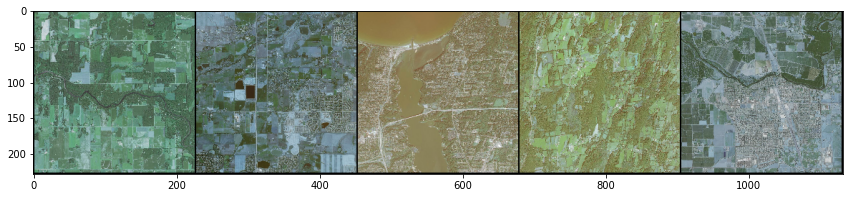

tensor([ 0.5491, -0.9231,  0.5491,  0.2235,  0.0412])


In [101]:
# visualize five images
inputs, labels = iter(train_dl).next()

five_images = inputs[:5,:,:,:]

def imshow(img):
#     img = img * 255.0     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (15,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # arrange the axis...
    plt.show()

imshow(torchvision.utils.make_grid(five_images))
print(labels[:5]) # auto shares. 

#### Extract only the conv1 layer

In [106]:
# to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [107]:
# def hook.
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [108]:
# register one hook
model.conv1.register_forward_hook(get_activation('conv1'))

In [123]:
# run the model
five_images = five_images.to(device)
outputs = model(five_images)

In [112]:
# get the conv1 layer
activation['conv1'].size()

torch.Size([5, 64, 112, 112])

#### Extract all the layers

In [122]:
# def hook again (function is the same as above)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [125]:
# register all the hooks. 
for name,module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(True)
        module.register_forward_hook(get_activation(name))
    

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [126]:
# run the model. It seems to be the way to activate the model.
five_images = five_images.to(device)
outputs = model(five_images)

In [127]:
for key in activation.keys():
    print(key)

conv1
layer1.0.conv1
conv2
layer1.0.conv2
layer1.1.conv1
layer1.1.conv2
layer2.0.conv1
layer2.0.conv2
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer3.0.conv1
layer3.0.conv2
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer4.0.conv1
layer4.0.conv2
layer4.0.downsample.0
layer4.1.conv1
layer4.1.conv2


In [131]:
print(activation['layer1.0.conv2'].size())
print(activation['conv1'].size())

torch.Size([5, 64, 56, 56])
torch.Size([5, 512, 7, 7])


# 3. Gradients

In [137]:
# Use one batch of data to compute gradients
inputs, labels = iter(train_dl).next()
inputs = inputs.to(device)
labels = labels.to(device)
outputs = model(inputs)
loss = criterion(outputs.view(-1), labels)
loss.backward() # backward - compute gradients?


In [139]:
# gradient w.r.t. conv1 layer.
print(model.conv1.weight.grad.size())
print(model.conv1.weight.grad)

torch.Size([64, 3, 7, 7])
tensor([[[[-14.0753,  -9.7539,   1.1408,  ...,  -9.6340,  -5.7534,   2.9263],
          [-15.2036, -16.6944, -17.4655,  ..., -10.2835, -10.2407, -14.6861],
          [ -5.9295, -15.8653,  -7.4699,  ...,  -9.8723, -10.3194,  -7.1199],
          ...,
          [-11.2973, -17.9336,  -4.5019,  ..., -13.2313, -14.8447,  -2.2457],
          [-15.2718, -20.7915, -25.0262,  ..., -12.1090, -16.6279, -24.4775],
          [-18.0918, -27.1595, -23.6825,  ..., -21.2753, -22.2008, -26.4932]],

         [[-11.1456,  -8.6961,   4.8656,  ...,  -9.3115,  -6.1815,   5.1567],
          [-12.9969, -14.3413, -14.0897,  ..., -10.9581, -10.1856, -13.0398],
          [ -2.7118, -11.1962,  -3.5508,  ..., -10.4010,  -8.6720,  -5.4794],
          ...,
          [ -4.2742, -12.8075,   2.7807,  ...,  -8.6863, -11.0706,   3.6297],
          [ -8.2948, -14.0702, -18.3792,  ...,  -7.6420, -11.7926, -19.1952],
          [-11.1092, -20.8594, -17.3558,  ..., -17.8118, -18.2341, -21.7934]],

    